### Loading the data

In [1]:
import pandas as pd


In [2]:
df=pd.read_csv("data.csv")

In [3]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [4]:
df.shape

(8518, 8)

In [5]:
df.dtypes

Reviewer Name       object
Review Title        object
Place of Review     object
Up Votes           float64
Down Votes         float64
Month               object
Review text         object
Ratings              int64
dtype: object

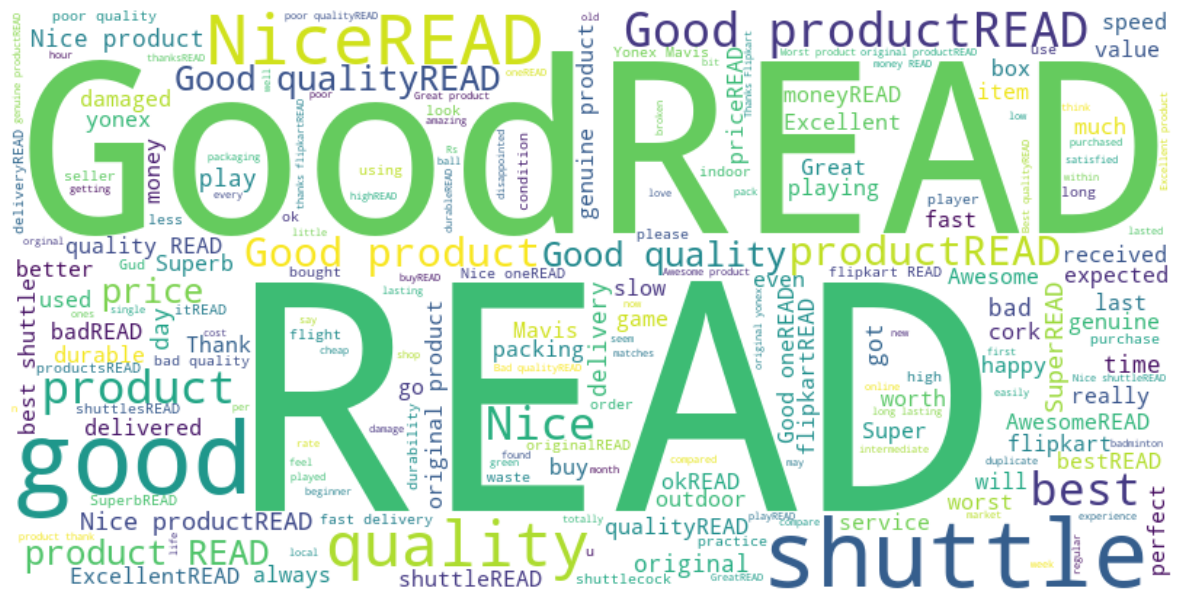

In [6]:
# Import necessary libraries
from wordcloud import WordCloud, STOPWORDS  
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the review text
# Convert all items to strings and handle NaN values
text = " ".join(str(review) for review in df["Review text"] if isinstance(review, str))

# Ensure that the text is not empty
if text:
    stopwords = set(STOPWORDS)
    additional_stopwords = {"one", "two", "three"}  # Example additional stopwords
    stopwords.update(additional_stopwords)

    wordcloud = WordCloud(stopwords=stopwords, 
                          background_color="white",
                          width=800, height=400,  
                          max_words=200,  
                          colormap='viridis',  
                          contour_width=1, contour_color='steelblue'  
                          ).generate(text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
else:
    print("No valid text data found in the 'Review text' column.")


### Step 1 - Identify Input and Output

In [7]:
# Step 1: Identify Input and Output

X = df['Review text'] # the column text contains textual data to extract features from
threshold = 4  # Define the threshold

def classify_sentiment(rating):
    if rating >= threshold:
        
        return 'positive'
    elif rating < threshold:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the 'Sentiment' column
df['Sentiment'] = df['Ratings'].apply(classify_sentiment)
y=df['Sentiment']

### Step 2 - Split the Data into Train and Test

In [8]:
# Step 2: Split the data into train and test

from sklearn.model_selection import train_test_split

# split X and y into training and testing sets. 
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6388,) (6388,)
(2130,) (2130,)


### Step 3 - Data Preprocessing on train data (X_train)

In [9]:
# Step 3: Data Preprocessing on train data (X_train)

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [10]:
def clean(doc): # doc is a string of text
    # This text contains a lot of <br/> tags.
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [11]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Replace NaN values with empty string
X_train.fillna('', inplace=True)  # Assuming X_train is your training data containing text

# Instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)  # Assuming you have defined a preprocessor function named 'clean'

# Use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)


Wall time: 10.6 s
(6388, 3001)


### Step 4 - Data Preprocessing on test data (X_test)

In [12]:
# Step 4: Data Preprocessing on test data (X_test)
X_test.fillna('', inplace=True) 

# transform testing data (using training data's features)

X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(2130, 3001)


### Step 5 - Building a Model (i.e. Train the classifier)

In [13]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

Wall time: 22 ms


MultinomialNB()

### Step 6 - Evaluating on Train Data

In [14]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.9035691922354414

In [15]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 763,  496],
       [ 120, 5009]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

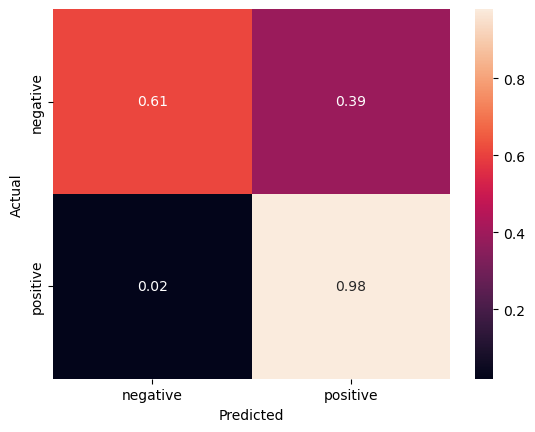

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Step 7 - Evaluate on Test Data

In [17]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.8694835680751174

Text(0.5, 23.52222222222222, 'Predicted')

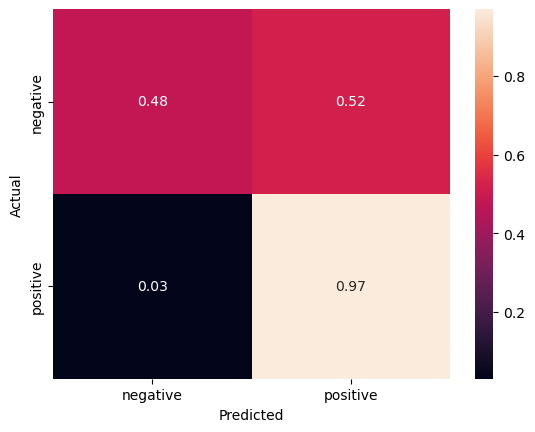

In [18]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [19]:
from sklearn import metrics

# Assuming your labels are 'negative' and 'positive'
pos_label = 'positive'

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred, pos_label=pos_label))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred, pos_label=pos_label))


Train Score (F1 Score): 0.942072597329321
Test Score (F1 Score): 0.9219977553310886


In [20]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

In [21]:
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [{'vectorization__preprocessor' : [clean],
                   'vectorization__max_features' : MAX_FEATURES, 
                   'nb__alpha' : ALPHA}]

clf = GridSearchCV(
    estimator=pipe, 
    param_grid=parameter_grid, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)
print()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

Wall time: 4min 59s
Best estimator found on train set
Pipeline(steps=[('vectorization',
                 CountVectorizer(max_features=1000,
                                 preprocessor=<function clean at 0x00000240CEA0D5E0>)),
                ('nb', MultinomialNB(alpha=1))])



In [22]:
from sklearn.metrics import f1_score

# Assuming your labels are 'negative' and 'positive'
pos_label = 'positive'

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred, pos_label=pos_label))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred, pos_label=pos_label))

# Calculate F1 score on test data
y_test_pred = clf.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred, pos_label=pos_label)
print('F1 Score on Test Data: ', test_f1_score)


Train Score (F1 Score): 0.942072597329321
Test Score (F1 Score): 0.9219977553310886
F1 Score on Test Data:  0.9214689265536723


In [23]:
import joblib
from joblib import Memory

import os

In [24]:
# Improving the efficiency by applying cleaning the text data before hand

%time X_train_clean = X_train.apply(lambda doc: clean(doc))

Wall time: 3.36 s


In [25]:
%time X_test_clean = X_test.apply(lambda doc: clean(doc))

Wall time: 1.17 s


In [26]:
import warnings

warnings.filterwarnings('ignore')

In [27]:
import numpy as np

print(np.unique(y_test))


['negative' 'positive']


In [28]:
y_train


6113    positive
1377    positive
2127    positive
3271    positive
8374    negative
          ...   
2895    positive
7813    positive
905     positive
5192    negative
235     negative
Name: Sentiment, Length: 6388, dtype: object

In [29]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on the target labels
label_encoder.fit(['negative', 'positive'])

# Transform the target labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the classes assigned to each label
print(label_encoder.classes_)


['negative' 'positive']


In [30]:
y_train_encoded

array([1, 1, 1, ..., 1, 0, 0])

In [31]:
import mlflow
from mlflow.sklearn import autolog

# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    # Enable MLflow autologging
    mlflow.sklearn.autolog()
    
    with mlflow.start_run() as run:
        grid_search.fit(X_train_clean, y_train_encoded)
        best_models[algo] = grid_search.best_estimator_
        
        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("f1_score", grid_search.best_score_)
        
        # Calculate F1 score on test data using y_test_encoded
        test_f1_score = grid_search.score(X_test_clean, y_test_encoded)
        mlflow.log_metric("test_f1_score", test_f1_score)

# Retrieve the best model from each algorithm
for algo, model in best_models.items():
    print(f"Best model for {algo}: {model}")


********** naive_bayes **********


2024/03/29 00:28:49 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/03/29 00:28:49 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2024/03/29 00:28:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}
2024/03/29 00:28:55 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/03/29 00:29:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


********** logistic_regression **********


2024/03/29 00:29:17 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


2024/03/29 00:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Best model for naive_bayes: Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=2000)),
                ('classifier', MultinomialNB(alpha=1))])
Best model for decision_tree: Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])
Best model for logistic_regression: Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.6,
                                    penalty='elasticnet', solver='saga'))])


In [34]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=2000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.6,
                                    penalty='elasticnet', solver='saga'))])



In [35]:
import os
import joblib
from sklearn import metrics

# Create the directory if it doesn't exist
if not os.path.exists('best_models'):
    os.makedirs('best_models')

for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    # Save the model
    joblib.dump(model, f'best_models/{name}.pkl')
    
    # Load the model
    model = joblib.load(f'best_models/{name}.pkl')
    
    # Predict and evaluate
    %time y_test_pred = model.predict(X_test_clean)
    print("Test Score (F1)", metrics.f1_score(y_test_encoded, y_test_pred))  # Use y_test_encoded
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

    

********** naive_bayes **********
Wall time: 15 ms
Test Score (F1) 0.9206886819079876
Model Size: 140214 Bytes
********** decision_tree **********
Wall time: 18 ms
Test Score (F1) 0.9150181108943996
Model Size: 88267 Bytes
********** logistic_regression **********
Wall time: 13.9 ms
Test Score (F1) 0.9062407571724344
Model Size: 103316 Bytes


In [25]:
import mlflow

In [26]:
mlflow.set_experiment("sentimental_prediction")

<Experiment: artifact_location='file:///C:/Users/Admin/sentimental_mlflow/mlruns/634194445145842668', creation_time=1711437573500, experiment_id='634194445145842668', last_update_time=1711437573500, lifecycle_stage='active', name='sentimental_prediction', tags={}>

In [27]:
mlflow.sklearn.autolog(max_tuning_runs=None)

In [30]:
with mlflow.start_run() as run:
    %time grid_search.fit(X_test_clean, y_test_encoded)


2024/03/26 13:31:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/03/26 13:31:04 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 6min 29s


In [33]:
 
    %time grid_search.fit(X_train_clean, y_train_encoded)  # Use y_train_encoded instead of y_train
    
    best_models[algo] = grid_search.best_estimator_
    
    # Calculate F1 score on test data using y_test_encoded
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test_encoded)) 

2024/03/26 15:18:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b1ddfcb1c1a84959a3fe9a71f4ff9ce7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/26 15:18:59 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 11min 9s
Score on Test Data:  0.9062407571724344


In [ ]:
mlflow.set_tracking_uri(data_uri)

In [44]:
from mlflow.tracking import MlflowClient

# Create an MLflow client
client = MlflowClient()

# Define the name of the registered model
registered_model_name = "sentimental_prediction_experimentations"

# Get the model version ID based on the name and version number
model_version_id = client.get_model_version(registered_model_name, 3).version

# Transition the model version stage
client.transition_model_version_stage(
    name=registered_model_name, version=model_version_id, stage="production"
)


<ModelVersion: aliases=[], creation_timestamp=1711451388756, current_stage='Production', description='', last_updated_timestamp=1711481613112, name='sentimental_prediction_experimentations', run_id='da753b74f9124ea7a5416600109208e4', run_link='', source='file:///C:/Users/Admin/sentimental_mlflow/mlruns/634194445145842668/da753b74f9124ea7a5416600109208e4/artifacts/best_estimator', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [45]:
from mlflow.tracking import MlflowClient

# Create an MLflow client
client = MlflowClient()

# Define the name of the registered model
registered_model_name = "sentimental_prediction_experimentations"

# Get the model version ID based on the name and version number
model_version_id = client.get_model_version(registered_model_name, 4).version

# Transition the model version stage
client.transition_model_version_stage(
    name=registered_model_name, version=model_version_id, stage="Archived"
)


<ModelVersion: aliases=[], creation_timestamp=1711451462064, current_stage='Archived', description='', last_updated_timestamp=1711481897926, name='sentimental_prediction_experimentations', run_id='8f62e8f86bbc49d18dded3db809e574e', run_link='', source='file:///C:/Users/Admin/sentimental_mlflow/mlruns/634194445145842668/8f62e8f86bbc49d18dded3db809e574e/artifacts/best_estimator', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [43]:
from mlflow.tracking import MlflowClient

# Create an MLflow client
client = MlflowClient()

# Get all registered models
registered_models = client.search_registered_models()
for model in registered_models:
    print("Registered Model Name:", model.name)


Registered Model Name: sentimental_prediction_experimentations


In [ ]:
client = MlflowClient()
client.transition_model_version_stage(
    name="sk-learn-random-forest-reg-model", version=2, stage="Archived"
)

In [ ]:
client = MlflowClient()
client.transition_model_version_stage(
    name="sk-learn-random-forest-reg-model", version=1, stage="staging"
)